#  Enhancing Deployment-time Predictive Model Robustness for Code Analysis and Optimization: Artifacts Evaluation Instructions

## Preliminaries

This interactive Jupyter notebook provides a small-scale demo for showcasing task definition, client RL search, client RL parameter tuning, and evaluation of case studies reported in the paper.

The main results of our CGO 2025 paper apply Prom to 5 case studies to detect their drifting samples. The evaluation presented in our paper ran on a much larger dataset and for longer. This notebook contains minimal working examples designed to be evaluated in a reasonable amount of time (approximately 20 minutes).

## Instructions for Experimental Workflow:

Before you start, please first make a copy of the notebook by going to the landing page. Then select the checkbox next to the notebook titled *main.ipynb*, then click "**Duplicate**".

Click the name of the newly created Jupyter Notebook, e.g. **AE-Copy1.ipynb**. Next, select "**Kernel**" > "**Restart & Clear Output**". Then, repeatedly press the play button (the tooltip is "run cell, select below") to step through each cell of the notebook.

Alternatively, select each cell in turn and use "**Cell**"> "**Run Cell**" from the menu to run specific cells. Note that some cells depend on previous cells being executed. If any errors occur, ensure all previous cells have been executed.

## Important Notes

**Some cells can take more than 30 minutes to complete; please wait for the results until step to the next cell.**

High load can lead to a long wait for results. This may occur if multiple reviewers are simultaneously trying to generate results.

The experiments are customisable as the code provided in the Jupyter Notebook can be edited on the spot. Simply type your changes into the code blocks and re-run using **Cell > Run Cells** from the menu.

## Links to The Paper

For each step, we note the section number of the submitted version where the relevant technique is described or data is presented.

The main results are presented in Figures 7-10 and Table 2 and 3 of the submitted paper.

# Demo 1: Tutorial for Prom

This demo corresponds to the simplified drifting detection example given in Figure 2. Note that we have refactored the code; hence there are small changes in the API. This is a small-scale demo for case study 1 of thread coarsening. The full-scale evaluation used in the paper takes over 24 hours to run.

## Step 1. Train the underlying model

This problem develops a model to determine the optimal OpenCL GPU thread coarsening factor for performance optimization. Following the original paper, an ML model predicts a coarsening factor (ranging  from 1 to 32) for a test OpenCL kernel, where 1 indicates no coarsening. Following the setup of  the DeepTune, we train and test the models using the labeled dataset  from them, comprising 17 OpenCL kernels from three benchmark  suites across four GPU platforms.

we train the baseline model using  leave-one-out cross-validation, which involves training the baseline model on 16 OpenCL kernels and testing on another one.
#### Training dataset and calibration dataset partitioning

In [1]:
import sys
sys.path.append('../case_study/Thread/')
from Magni_utils import ThreadCoarseningMa,Magni,make_predictionMa,make_prediction_ilMa
from Thread_magni import load_magni_args_notebook,load_magni_args
from src.prom.prom_util import Prom_utils

print("Starting to partition the training and calibration datasets...")

# Load necessary arguments for the program, related to model configuration or runtime settings
# args = load_magni_args_notebook()
args = load_magni_args()
seed_value = int(args.seed)
# Initialize a thread coarsening model object for the Magni model
prom_thread = ThreadCoarseningMa(model=Magni())

# Define the path to the dataset and the target platform (here, "Tahiti" refer to a GPU architecture or hardware)
dataset_path = "../../benchmark/Thread"
platform = "Tahiti"

# Perform data partitioning for training, validation, and testing.
# The method 'data_partitioning' returns the split data, including features (X) and labels (y)
# Additionally, it returns calibration data and indices for each partition (train, validation, and test).
# Args could contain hyperparameters or settings used during data partitioning (such as shuffle, split ratios, etc.)
X_cc, y_cc,train_x, valid_x, test_x, train_y, valid_y, test_y, \
        calibration_data,cal_y,train_index, valid_index, test_index,y,X_seq,y_1hot=\
            prom_thread.data_partitioning(dataset_path,platform=platform,mode='train', calibration_ratio=0.1,args=args)

# 'X_cc', 'y_cc' : The coarsened features and labels (thread coarsening context)
# 'train_x', 'valid_x', 'test_x' : Training, validation, and testing features (input data)
# 'train_y', 'valid_y', 'test_y' : Training, validation, and testing labels (output data)
# 'calibration_data', 'cal_y' : Calibration data and labels, for model tuning or confidence calibration
# 'train_index', 'valid_index', 'test_index' : Indexes for the split datasets (training, validation, test)
# 'y', 'X_seq', 'y_1hot' : Other data representations (e.g., one-hot encoding, sequence features/labels)
print("Data splitting process completed!")

Starting to partition the training and calibration datasets...
Data splitting process completed!


#### Training the underlying model


In [2]:
print("Starting the training process for the underlying model...")

# Initialize the model with the provided arguments
# The 'args' contain configurations or hyperparameters needed to set up the model (e.g., learning rate, batch size, etc.)
prom_thread.model.init(args)

# Train the model using the training data (features and labels)
# 'cascading_features' refers to the input features for training (possibly related to thread coarsening features)
# 'cascading_y' is the corresponding target labels for the training data
# 'verbose=True' enables the printing of training progress or detailed output during the training process
prom_thread.model.train(
    cascading_features=train_x,
    verbose=True,
    cascading_y=train_y)

# Initialize empty lists to store results
# 'origin_speedup_all' will hold the original speedup values
# 'speed_up_all' will store the predicted speedup values from the model
# 'improved_spp_all' will track any improvements in speedup across predictions
origin_speedup_all = []
speed_up_all = []
improved_spp_all = []

# Call 'make_predictionMa' to make predictions using the trained model
# Arguments:
#   - 'speed_up_all': A list to collect the speedup predictions from the model
#   - 'platform': The target platform (e.g., "Tahiti") for which the prediction is made
#   - 'model': The trained model (prom_thread.model)
#   - 'test_x': Features for the test data
#   - 'test_index': Indices of the test data
#   - 'X_cc': Additional features (possibly coarsened or cascading features)
origin_speedup, all_pre, data_distri = make_predictionMa(speed_up_all=speed_up_all,
                                                         platform=platform,
                                                         model=prom_thread.model,
                                                         test_x=test_x,
                                                         test_index=test_index,
                                                         X_cc=X_cc)

# Print the original speedup obtained from the prediction for the specified platform
print(f"The speedup on the Titan is {origin_speedup:.2%}")

Starting the training process for the underlying model...
The speedup on the Titan is 93.14%


#### Training the anomaly detector

In [3]:
print("Starting the construction of the anomaly detector...")

# Set the trained classifier model from prom_thread
clf = prom_thread.model

# Define the prom parameters (method_params) for different evaluation metrics:
method_params = {
    "lac": ("score", True),
    "top_k": ("top_k", True),
    "aps": ("cumulated_score", True),
    "raps": ("raps", True)
}

# Initialize a Prom object for performing conformal prediction and evaluation
# 'task' is set to "thread" indicating the specific task being modeled
Prom_thread = Prom_utils(clf, method_params, task="thread")

# Perform conformal prediction:
#   - 'cal_x' and 'cal_y' are the calibration data and labels,
#   - 'test_x' and 'test_y' are the test data and labels,
#   - 'significance_level' is set to "auto" for automatic adjustment.
y_preds, y_pss, p_value = Prom_thread.conformal_prediction(
    cal_x=calibration_data, 
    cal_y=cal_y, 
    test_x=test_x,
    test_y=test_y,
    significance_level="auto"
)
print("The anomaly detector has been successfully constructed.")

Starting the construction of the anomaly detector...
The anomaly detector has been successfully constructed.


# Train the prom anolamy detector

## Step 2. Prom on deployment

First, to introduce data drift, we train the ML models on OpenCL benchmarks from two suites and then test the trained model on another left-out benchmark suite.

#### Native deployment



In [4]:
# load the model
prom_thread.model.restore(r'../../examples/case_study/Thread/ae_savedmodels/tutorial/Tahiti-underlying.model')
# make prediction
origin_speedup,all_pre,data_distri=make_predictionMa(speed_up_all=speed_up_all,
                                       platform=platform,model=prom_thread.model,
                test_x=test_x,test_index=test_index,X_cc=X_cc)
print(f"Loading successful, the deployment speedup on the {platform} is {origin_speedup:.2%}")
origin = sum(speed_up_all) / len(speed_up_all)

Loading successful, the deployment speedup on the Tahiti is 57.19%


#### Detecting drifting samples

In [5]:
# Perform evaluation of the conformal prediction, retrieving accuracy and other metrics:
#   - 'index_all_right', 'index_list_right' store indices where predictions are correct,
#   - 'Acc_all', 'F1_all', 'Pre_all', 'Rec_all' store accuracy, F1-score, precision, and recall respectively.
index_all_right, index_list_right, Acc_all, F1_all, Pre_all, Rec_all, _, _ = \
    Prom_thread.evaluate_conformal_prediction(
        y_preds=y_preds,
        y_pss=y_pss,
        p_value=p_value,
        all_pre=all_pre,
        y=y[test_index],
        significance_level=0.05
    )

_____________The detection performance can be seen below_____________
The accuracy for detection on lac is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on top_k is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on aps is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on raps is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on mixture is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
lac is the best approach，the accuracy is: 100.00%, the precision is: 100.00%, the recall is: 100.00%, the F1 is: 100.00%
______________________________________


## Step 3. Improve Deployment Time Performance
Prom can enhance the performance of deployed ML systems through incremental learning.

#### Retraining the model with incremental learning:

In [6]:
# Perform incremental learning by selecting the most valuable instances to add to the training set:
#   - 'seed_value' is used for randomization,
#   - 'test_index' and 'train_index' are updated accordingly.
print("Finding the most valuable instances for incremental learning...")
train_index, test_index = Prom_thread.incremental_learning(
    seed_value, 
    test_index, 
    train_index
)
# Fine-tune the model using the updated training set:
#   - 'X_seq[train_index]' is the updated training data,
#   - 'y_1hot[train_index]' are the corresponding labels in one-hot encoding format.
print(f"Retraining the model on {platform}...")
prom_thread.model.fine_tune(
    cascading_features=X_seq[train_index],
    cascading_y=y_1hot[train_index],
    verbose=True
)

# Test the fine-tuned model and make predictions using the updated model:
#   - 'speed_up_all' stores the predicted speedup values,
#   - 'improved_spp_all' stores improvements in speedup,
#   - 'origin_speedup' refers to the initial speedup before fine-tuning.
retrained_speedup, inproved_speedup, data_distri = make_prediction_ilMa(
    speed_up_all=speed_up_all, 
    platform=platform,
    model=prom_thread.model,
    test_x=X_seq[test_index],
    test_index=test_index, 
    X_cc=X_cc,
    origin_speedup=origin_speedup,
    improved_spp_all=improved_spp_all
)

origin_speedup_all.append(origin_speedup)
speed_up_all.append(retrained_speedup)
improved_spp_all.append(inproved_speedup)

mean_acc = sum(Acc_all) / len(Acc_all)
mean_f1 = sum(F1_all) / len(F1_all)
mean_pre = sum(Pre_all) / len(Pre_all)
mean_rec = sum(Rec_all) / len(Rec_all)
# Calculate the mean speed-up (speed_up_all is a list of all speed-ups)
mean_speed_up = sum(speed_up_all) / len(speed_up_all)

# Calculate the improved mean speed-up (improved_spp_all is a list of improved speed-ups)
meanimproved_speed_up = sum(improved_spp_all) / len(improved_spp_all)

# Output the model's average accuracy, precision, recall, and F1 score, formatted as percentages
print(
    f"Average accuracy: {mean_acc * 100:.2f}%, "
    f"Average precision: {mean_pre * 100:.2f}%, "
    f"Average recall: {mean_rec * 100:.2f}%, "
    f"Average F1 score: {mean_f1 * 100:.2f}%"
)

# Output the average speed-up and the improved average speed-up
print(
    f"Average speed-up: {mean_speed_up:.2f}, "
    f"Improved average speed-up: {meanimproved_speed_up:.2f}"
)

# Output the final improved speed-up as a percentage
print(f"Final improved speed-up percentage: {meanimproved_speed_up * 100:.2f}%")


Finding the most valuable instances for incremental learning...
Retraining the model on Tahiti...
The retrained speed up is  0.8627036071059495 the improved speed up is  0.2907569525353487
Average accuracy: 100.00%, Average precision: 100.00%, Average recall: 100.00%, Average F1 score: 100.00%
Average speed-up: 0.81, Improved average speed-up: 0.29
Final improved speed-up percentage: 29.08%


# Demo 2: Experimental Evaluation

Here, we provide a small-sized evaluation to showcase the working mechanism of the Prom on five case studies. A full-scale evaluation, which takes more than a day to run, is provided through the Docker image (with detailed instructions on our project Github).

### Case Study 1: Thread Coarsening (Section 6.1)

This problem develops a model to determine the optimal OpenCL GPU thread coarsening factor for performance optimization. Following other works, an ML model predicts a coarsening factor (ranging  from 1 to 32) for a test OpenCL kernel, where 1 indicates no coarsening. Underlying models. We train the baseline model using  leave-one-out cross-validation, which involves training the base-  line model on 16 OpenCL kernels and testing on another one. We  then repeat this process until all benchmark suites have been tested  once. To introduce data drift, we train the ML models on OpenCL  benchmarks from two suites and then test the trained model on  another left-out benchmark suite.

This demo corresponds to Figure 7(a), 8(a), 9(a), 11(a) of the submitted manuscript.

*approximate runtime = 10 minutes for one benchmark*

In [3]:
!python ae_thread.py

*****************Tahiti***********************
Loading dataset on Tahiti...
Loading underlying model...
Loading successful, the speedup on the Tahiti is 93.14%
training finished
final percent: 0.9313518035529748
*****************Tahiti***********************
Loading dataset on Tahiti...
Loading underlying model...
Loading successful, the speedup on the Tahiti is 78.43%
training finished
Start conformal prediction on Tahiti...
_____________The MAPIE detection performance can be seen below_____________
The accuracy for detection on lac is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on top_k is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on aps is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on raps is: 100.00%, precision is: 100.00%, recall is: 100.00%, F1 is: 100.00%
The accuracy for detection on mixture is: 100.00%, precision is: 100.00

The improved performance is: [0.17753636]
The retrained model performance is [0.96891311]


## Full-scale evaluation data

We now plot the diagrams using full-scale evaluation data. 
The results correspond to Figure 7(a), 8(a), 9(a) and 11(a) of the submitted manuscript.

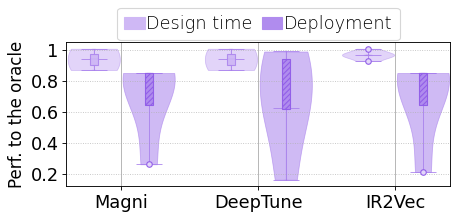

Figure 7(a) C1: thread coarsening. The resulting performance when using an ML model for decision making.


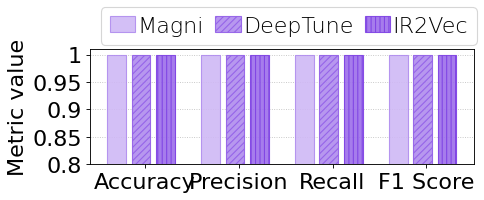

Figure 8(a) C1: thread coarsening. Prom’s performance for detecting drifting samples across case studies and underlying models.


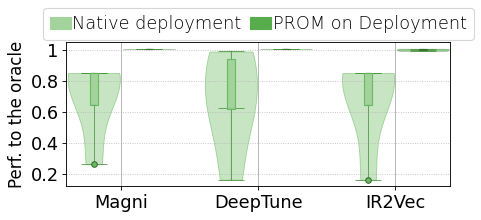

Figure 9(a) C1: thread coarsening. Prom enhances performance through incremental learning in different underlying models.


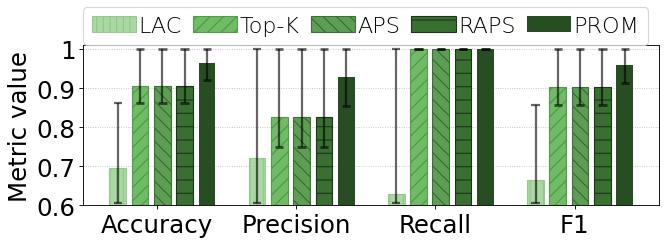

Figure 11(a) C1: Performance of individual nonconformity functions.


In [2]:
%run ae_plot.py

### Case Study 2: Loop Vectorization (Section 6.2)

This task constructs a predictive model to determine the optimal Vectorization Factor (VF) and Interleaving Factor (IF) for individual  vectorizable loops in C programs [34, 48]. Following [34], we ex-  plore 35 combinations of VF (1, 2, 4, 8, 16, 32, 64) and IF (1, 2, 4, 8, 16). We initially allocate 80% (4800)  of loop programs for training the model, reserving the remaining 20% (1200) for testing its performance. To introduce data drift, we  use loop programs generated from 14 benchmarks for training  and evaluate the model on the programs from the remaining 4  benchmarks. This ensures that the function and content of test  samples are not encountered during the training phase.

This demo corresponds to Figure 7(b), 8(b), 9(b) and 11(b) of the submitted manuscript.

*approximate runtime = 10 minutes for one benchmark*


In [ ]:
# Train the underlying model and deploy to drifting environment. The results correspond to Figure 7(b).
python model_definition.py --model trained_model.pkl
python prom_train.py --calibration_data calibration_data.pkl

# Using prom to detect the drifting data. The results correspond to Figure 8(b) and Figure 11(b).
python deploy_model.py --model trained_model.pkl --test_data /path/to/test_data.pkl --non_func all

# Increment learning with detected misprediction samples. The results correspond to Figure 9(b).
python retrain_model.py --model trained_model.pkl --new_data /path/to/new_data.pkl --retrain_ratio 0.05

### Case Study 3: Heterogeneous Mapping (Section 6.3)

This task develops a binary classifier to determine if the CPU or  the GPU gives faster performance for an OpenCL kernel. We train and evaluate the baseline  model using 10-fold cross-validation. This involves training a model  on programs from all but one of the sets and then testing it on the  programs from the remaining set. To introduce data drift, we train  the models using 6 benchmark suites and then test the trained  models on the remaining suite. We repeat this process until all  benchmark suites have been tested at least once.

This demo corresponds to Figure 7(c), 8(c), 9(c) and 11(c) of the submitted manuscript.

*approximate runtime = 10 minutes for one benchmark*

In [ ]:
# Train the underlying model and deploy to drifting environment. The results correspond to Figure 7(c).
python model_definition.py --model trained_model.pkl
python prom_train.py --calibration_data calibration_data.pkl

# Using prom to detect the drifting data. The results correspond to Figure 8(c) and Figure 11(c).
python deploy_model.py --model trained_model.pkl --test_data /path/to/test_data.pkl --non_func all

# Increment learning with detected misprediction samples. The results correspond to Figure 9(c).
python retrain_model.py --model trained_model.pkl --new_data /path/to/new_data.pkl --retrain_ratio 0.05

### Case Study 4: Vulnerability Detection (Section 6.4)

This task develops an ML classifier to predict if a given C function  contains a potential code vulnerability.

This demo corresponds to Figure 7(d), 8(d), 9(d) and 11(d) of the submitted manuscript. We consider the top-8 most dangerous types of bugs from the 2023 CWE. As with prior approaches, we initially train the  model on 80% of the randomly selected samples and evaluate its  performance on the remaining 20% samples. Then, we introduce  data drift by training the model on data collected between 2013 and 2020 and testing the trained model on samples collected between 2021 and 2023.

*approximate runtime = 10 minutes for one benchmark*

In [ ]:
# Train the underlying model and deploy to drifting environment. The results correspond to Figure 7(d).
python model_definition.py --model trained_model.pkl
python prom_train.py --calibration_data calibration_data.pkl

# Using prom to detect the drifting data. The results correspond to Figure 8(d) and Figure 11(d).
python deploy_model.py --model trained_model.pkl --test_data /path/to/test_data.pkl --non_func all

# Increment learning with detected misprediction samples. The results correspond to Figure 9(d).
python retrain_model.py --model trained_model.pkl --new_data /path/to/new_data.pkl --retrain_ratio 0.05

### Case Study 5: DNN Code Generation (Section 6.5)

This task builds a regression-based cost model to drive the schedule  search process in TVM for DNN code generation on multi-core CPUs. The cost model estimates the potential gain of a schedule (e.g., instruction orders and data placement) to guide the search. For the baseline, we train and test the cost model on  the BERT-base dataset, where the model is trained on 80% randomly  selected samples and then tested on the remaining 20% samples. To introduce data drift, we tested the trained model on the other  three variants of the BERT model and ResNet-50.

This demo corresponds to Table 2 of the submitted manuscript.

*approximate runtime = 10 minutes for one benchmark*

In [ ]:
# Train the underlying model and deploy to drifting environment. The results correspond to Figure 7(d).
python model_definition.py --model trained_model.pkl
python prom_train.py --calibration_data calibration_data.pkl

# Using prom to detect the drifting data. The results correspond to Figure 8(d) and Figure 11(d).
python deploy_model.py --model trained_model.pkl --test_data /path/to/test_data.pkl --non_func all

# Increment learning with detected misprediction samples. The results correspond to Figure 9(d).
python retrain_model.py --model trained_model.pkl --new_data /path/to/new_data.pkl --retrain_ratio 0.05

### Compare to Other CP-based Methods (Section 7.5)

This experiment compares Prom with RISE, developed for  wireless sensing, and TESSERACT, designed for malware classification.

In [ ]:
# The results correspond to Figure 10.
sh compare_rise.sh
sh compare_tesseract.sh